# Set up

## Python path

In [1]:
from pathlib import Path
import sys

# Add the parent directory to the system path
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

## Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix, build_design_matrices
import seaborn as sns

import const
import utils

## Constants

## Set defaults

In [3]:
utils.set_default_plot_style()

## Functions

In [4]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""
    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None, knot_strategy='even'):
        self.knots = knots
        self.min, self.max = min, max
        self.knot_strategy = knot_strategy
        if knots is None:
            if n_knots is None:
               n_knots = self._compute_n_knots(n_params)
            self.n_knots = n_knots
        else:
            self.n_knots = len(knots)

    def fit(self, X, *args, **kwargs):
        if self.min is None:
            self.min = X.min()
        if self.max is None:
            self.max = X.max()
        if self.knots is None:
            if self.knot_strategy == 'even':
                self.knots = np.linspace(self.min, self.max, num=(self.n_knots + 2))[1:-1]
            elif self.knot_strategy == 'quantiles':
                quantiles = np.linspace(0.0, 1.0, num=(self.n_knots + 2))[1:-1]
                self.knots = np.quantile(X, quantiles)
        return self

class CubicSpline(AbstractSpline):
    """Apply a piecewise cubic basis expansion to an array.


    The features created with this basis expansion can be used to fit a
    piecewise cubic function.  The fitted curve is continuously differentiable
    to the second order at all of the knots.

    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    min: float
        Minimum of interval containing the knots.

    max: float
        Maximum of the interval containing the knots.

    n_knots: positive integer
        The number of knots to create.

    knot_strategy: str
        Strategy for determining the knots at fit time. Current options are:
          - 'even': Evenly position the knots within the range (min, max).
          - 'quantiles': Set the knots to even quantiles of the data distribution.

    knots: array or list of floats
        The knots.
    """
    def _compute_n_knots(self, n_params):
        return n_params - 3

    @property
    def n_params(self):
        return self.n_knots + 3

    def transform(self, X, **transform_params):
        if isinstance(X, pd.DataFrame):
            assert X.shape[1] == 1
            X = X.iloc[:, 0]
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        second_name = "{}_spline_quadratic".format(X.name)
        third_name = "{}_spline_cubic".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots)]
        return [first_name, second_name, third_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = np.asarray(X).reshape(-1)
        X_spl = np.zeros((X.shape[0], self.n_knots + 3))
        X_spl[:, 0] = X
        X_spl[:, 1] = X_spl[:, 0] * X_spl[:, 0]
        X_spl[:, 2] = X_spl[:, 1] * X_spl[:, 0]
        for i, knot in enumerate(self.knots, start=3):
            X_spl[:, i] = np.maximum(0, (X - knot)*(X - knot)*(X - knot))
        return X_spl


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.

    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.

    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    min: float
        Minimum of interval containing the knots.

    max: float
        Maximum of the interval containing the knots.

    n_knots: positive integer
        The number of knots to create.

    knot_strategy: str
        Strategy for determining the knots at fit time. Current options are:
          - 'even': Evenly position the knots within the range (min, max).
          - 'quantiles': Set the knots to even quantiles of the data distribution.

    knots: array or list of floats
        The knots.
    """
    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        if isinstance(X, pd.DataFrame):
            assert X.shape[1] == 1
            X = X.iloc[:, 0]
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                     for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = np.asarray(X).reshape(-1)
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError:
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X

        def d(knot_idx, x):
            ppart = lambda t: np.maximum(0, t)
            cube = lambda t: t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                            - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X))
        return X_spl

# Generate sample data

In [5]:
try:
    sample_data = pd.read_csv(const.SPLINE_SAMPLE_DATA_PATH)
    x = sample_data["x"].values
    y = sample_data["y"].values
except FileNotFoundError:
    %pip install regressio --upgrade
    from regressio.datagen import generate_random_walk

    x, y = generate_random_walk(200, plot=False)
    x /= x.max()
    sample_data = pd.DataFrame({"x": x, "y": y})
    sample_data.to_csv(const.SPLINE_SAMPLE_DATA_PATH, index=False)

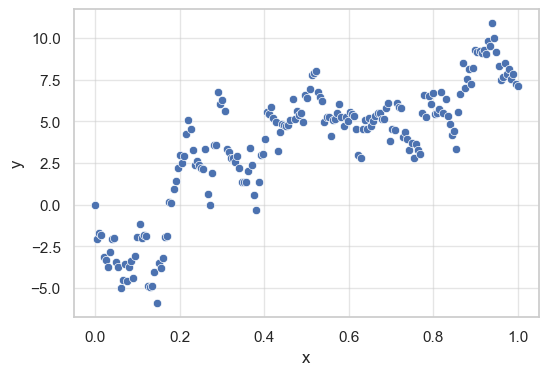

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(sample_data, x="x", y="y",ax=ax);

# 5.2 Piecewise Polynomials and Splines

## Splines

Suppose we have $K$ *knots* $\xi_1<\cdots \xi_K$.
An order-$M$ spline with knots $\xi_j$ is a piecewise polynomial of order $M$ on each interval $(-\infty, \xi_1), (\xi_1, \xi_2), \ldots (\xi_{K-1}, \xi_K), (\xi_K, \infty)$ with continuous derivatives up to order $M-2$ at each knot.

Note that order $M$ means degree $d=M-1$.
In practice we only ever use $M=2$, piecewise linear curves, or $M=4$, cubic splines.

A simple default for knot placement is to use quantiles of the data.

## Degrees of freedom

An order-$M$ spline consists of $K+1$ order $M$ polynomials, each contributing $M$ degrees of freedom.
The boundary conditions at the $K$ knots each remove $M-2$ degrees of freedom, so in total we have

\begin{equation*}
    \text{df} = M + K
\end{equation*}

## Spline bases

There are many equivalent splines bases.
The *$B$-spline* basis is efficient even for large $K$ so is often used.

The B-spline basis involves adding $M$ boundary knots outside the domain of your data.
So, when fitting cubic splines on data defined on [0, 1] we might add (interior) knots at 0.25, 0.5, and 0.75 and 4 boundary knots each at 0 and 1.
Some implementations (`patsy`) do this automatically but some (`scipy.interpolate.BSpline`) require you to specify the boundary knots.

## `patsy`

`patsy` is a convenient package for splines.
It takes care of generating the design matrices.

There is also an implementation in `scipy.interpolate.BSpline` but I find it less intuitive.
This allows extrapolation using the outer fitted polynomials, but this is probably a bad idea.

### Linear regression

As an introduction to the package we'll start by just doing linear regression.

In [54]:
# design matrix for y ~ x + 1 (intercept is automatically added)
dmatrix("x", {"x": [1, 2, 3]})

DesignMatrix with shape (3, 2)
  Intercept  x
          1  1
          1  2
          1  3
  Terms:
    'Intercept' (column 0)
    'x' (column 1)

In [55]:
# we can remove the intercept by adding '-1'
dmatrix("x - 1", {"x": [1, 2, 3]})

DesignMatrix with shape (3, 1)
  x
  1
  2
  3
  Terms:
    'x' (column 0)

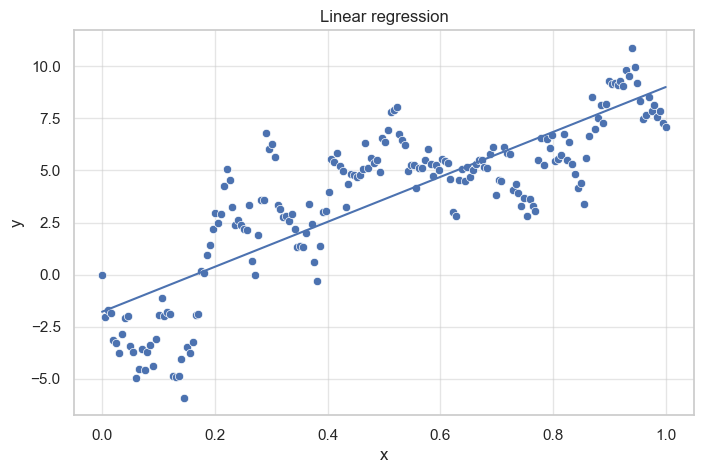

In [56]:
# can then train a linear model on the design matrix
X = dmatrix("x", sample_data.x)

# the intercept is already in the design matrix
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, sample_data.y)
y_pred = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y",ax=ax)
ax.plot(sample_data.x, y_pred)
ax.set(title="Linear regression");

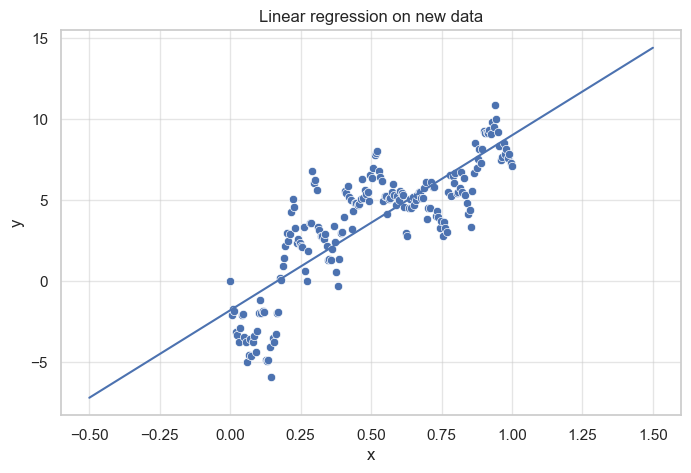

In [22]:
# to make a prediction on new data make a new design matrix based on the fitted one
x_new = np.linspace(-0.5, 1.5, 100)
X_new = build_design_matrices([X.design_info], {"x": x_new})[0]

y_pred_new = lin_reg.predict(X_new)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y",ax=ax)
ax.plot(x_new, y_pred_new)
ax.set(title="Linear regression on new data");

### Cubic splines

To fit cubic splines we repeat the above, just changing the formula that goes into the design matrix.
By default, `patsy` takes quantiles of the data for the position of the knots, but this is configurable with the `knots` argument.

In [62]:
X = dmatrix("bs(x, df=7, degree=3, include_intercept=True) - 1", {"x": x})
X

DesignMatrix with shape (200, 7)
  Columns:
    ['bs(x, df=7, degree=3, include_intercept=True)[0]',
     'bs(x, df=7, degree=3, include_intercept=True)[1]',
     'bs(x, df=7, degree=3, include_intercept=True)[2]',
     'bs(x, df=7, degree=3, include_intercept=True)[3]',
     'bs(x, df=7, degree=3, include_intercept=True)[4]',
     'bs(x, df=7, degree=3, include_intercept=True)[5]',
     'bs(x, df=7, degree=3, include_intercept=True)[6]']
  Terms:
    'bs(x, df=7, degree=3, include_intercept=True)' (columns 0:7)
  (to view full data, use np.asarray(this_obj))

Note the default is `include_intercept=False`, but setting it to `True` agrees with and removing the `Intercept` column makes the number of knots agree with our formulation above: $\text{df} = K + 4$.
Setting it to false effectively reduces the degrees of freedom, and hence the number of knots, by 1.

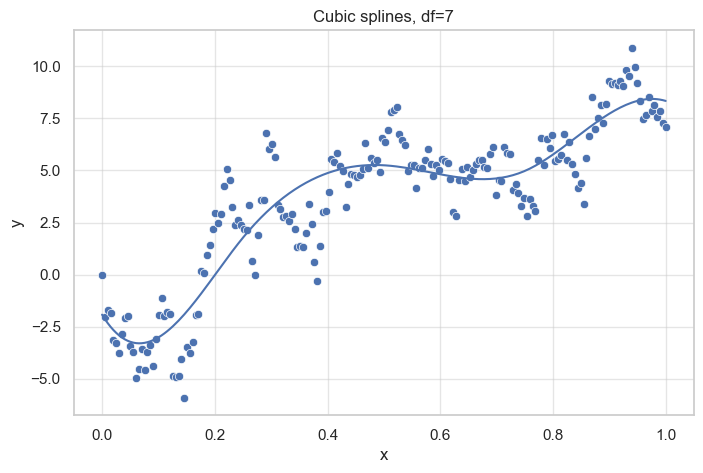

In [64]:
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(sample_data, x="x", y="y", ax=ax)
ax.plot(sample_data.x, y_pred)
ax.set(title="Cubic splines, df=7");

`patsy` uses B-spline bases.
We can visualise the individual basis functions.

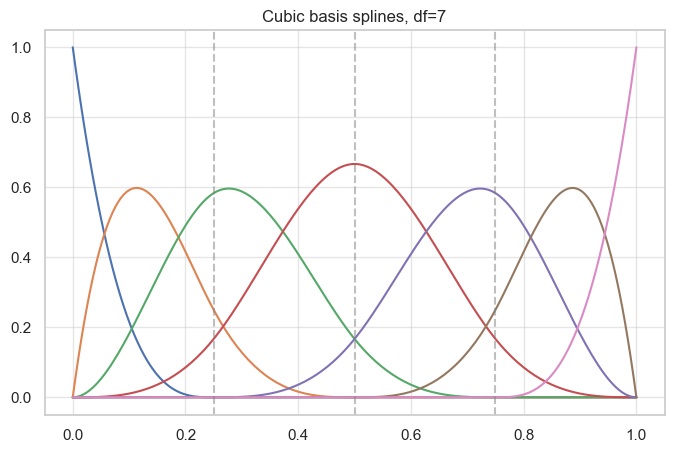

In [80]:

fig, ax = plt.subplots(figsize=(8, 5))

# plot the basis functions
b = np.ones(7)
ax.plot(x, X*b)

# plot knot locations
n_knots = 7 - 4
knots = np.linspace(x.min(), x.max(), num=n_knots + 2)[1:-1]
for knot in knots:
    ax.axvline(knot, color="gray", linestyle="--", alpha=0.5)

ax.set(title="Cubic basis splines, df=7");

We can see how changing the degrees of freedom affects the spline curve

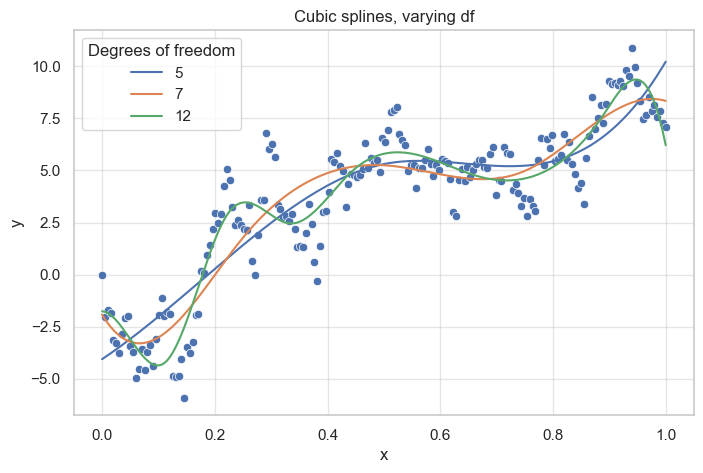

In [83]:
degrees_of_freedom = [5, 7, 12]

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y", ax=ax)

for df in degrees_of_freedom:
    X = dmatrix(f"bs(x, df={df}, degree=3, include_intercept=True) - 1", {"x": x})

    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(X, y)
    y_pred = lin_reg.predict(X)

    ax.plot(sample_data.x, y_pred, label=str(df))

ax.set(title="Cubic splines, varying df")
ax.legend(title="Degrees of freedom");

## Natural cubic splines

The plot above suggests that cubic splines have high variance near the boundary.
We can reduce this by adding the additional constraint that the function is linear outside the boundary knots.
Such a spline is called a *natural cubic spline*.

*Note:* There is some ambiguity around what we mean by 'outside the boundary knots'.
The construction in the chapter takes this to mean $\xi_1$ and $\xi_K$, but in the definition of B-splines at the end of the chapter we add additional knots $\xi_0$ and $\xi_{K+1}$ which are described as 'boundary knots'.
The question is whether we constrain the function to be linear outside the bounds of the data or if that restriction starts within the data range.

This also has an effect on the degrees of freedom.
If we do not add additional boundary knots then natural cubic splines have $\text{df}=K$, since we remove two degrees of freedom at each end.
If we do add two boundary knots then those add back in two degrees of freedom, so $\text{df}=K+2$.

### `patsy`

`patsy` has an implementation of natural cubic splines using modified B-splines.
Note that it chooses to add the minimum and maximum of the data as additional boundary knots and enforces linearity outside those bounds.
As a consequence, the number of (inner) knots is $\text{df} - 2$.

The other implementation can be found at https://github.com/madrury/basis-expansions.

Scipy has an implementation at `scipy.interpolate.CubicSpline` but this only supports knots at the $x$-values of the data (we will do this below).
It might be possible to work around this using `scipy.interpolate.make_lsq_spline`.

We can compare cubic splines and natural cubic splines with the same number of degrees of freedom.
The regular cubic splines can't extrapolate, but the natural splines are able to extrapolate linearly.

In [147]:
def fit_predict_from_dmatrix(X, y, x_pred):
    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(X, y)
    X_pred = build_design_matrices([X.design_info], {"x": x_pred})[0]
    return lin_reg.predict(X_pred)

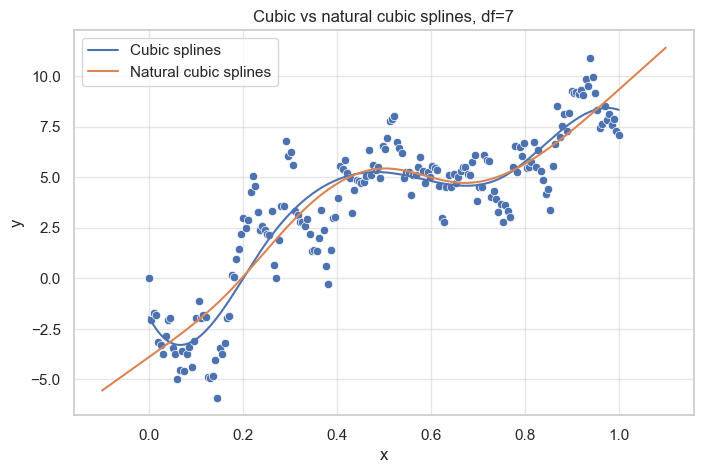

In [152]:
X = dmatrix("bs(x, df=7,  degree=3, include_intercept=True) - 1", {"x": x})
X_nat = dmatrix("cr(x, df=7) - 1", {"x": x})

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(sample_data, x="x", y="y", ax=ax)

x_pred = x
y_pred = fit_predict_from_dmatrix(X, y, x_pred)
ax.plot(x_pred, y_pred, label="Cubic splines")

# extend to show extrapolation
x_pred = np.linspace(-0.1, 1.1, 200)
y_nat_pred = fit_predict_from_dmatrix(X_nat, y, x_pred)
ax.plot(x_pred, y_nat_pred, label="Natural cubic splines")


ax.set(title="Cubic vs natural cubic splines, df=7")
ax.legend();

Note how the natural cubic splines are regularised near the boundary.